In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets


In [2]:
img_size = 224
lr = 0.0005

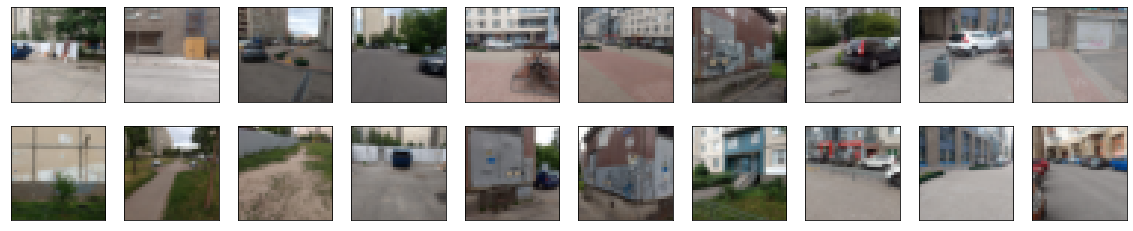

In [3]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('data/train', 
                                                                            transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [4]:
image_transforms = {'train': transforms.Compose([transforms.Resize(img_size),
                                     transforms.CenterCrop(img_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   }

loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder('data/train', 
                                                                            transform=image_transforms['train']),
                                                        batch_size=128, shuffle=True),                    
                   }


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.c2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=6272, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=412)
        self.fc4 = nn.Linear(in_features=412, out_features=133)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.c1(x), 3))
        x = F.relu(F.max_pool2d(self.c2(x), 3))
        x = F.relu(F.max_pool2d(self.c3(x), 3))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
model = Net()

In [7]:
if torch.cuda.is_available():
    model.cuda()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)


In [13]:
for epoch in range(5):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['train']):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    print('Training accuracy: {:.0%}'.format(total_correct/total))
    if total_correct/total > 0.8:
        torch.save(model.state_dict(), 'pt/XRP_' + str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

Epoch:  0
Loss:  0.3736911416053772
Training accuracy: 87%
Epoch:  1
Loss:  0.3616432845592499
Training accuracy: 87%
Epoch:  2
Loss:  0.3455459475517273
Training accuracy: 91%
Epoch:  3
Loss:  0.32701706886291504
Training accuracy: 91%
Epoch:  4
Loss:  0.3062298595905304
Training accuracy: 91%
